In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm
import pandas as pd
import numpy as np
import os

from glob import glob
from datetime import datetime
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit

from utils import fileio
from utils import visualise
from utils import geometry
from utils import matrices
from source import segmentation_hand

In [3]:
def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

In [4]:
def make_polygon(i, C, R, cell_centres):
    """
    Generate polygon

    Parameters:
    i (int): cell id
    C (numpy array): Nc x Nv order array relating cells to vertices
    R (numpy array): vertex coordinates
    cell_centres (numpy array): cell centre coordinates
    """

    Ralpha=R[np.where(C[i,:]==1)[0]]-cell_centres[i] #ref frame of cell
    ang=np.arctan2(Ralpha[:,1], Ralpha[:,0])%(2*np.pi) #find angle with x axis
    R_ang=np.transpose(np.vstack((np.where(C[i,:]==1)[0], ang))) #stack index of vertices with angle
    ordered_vertices=R_ang[np.argsort(R_ang[:,-1], axis=0)] #sort by anticlockwise angle
    polygon = Polygon(R[ordered_vertices[:,0].astype(int)],closed = True)
    return polygon

def plot_edges(A, R):
    N_e=np.shape(A)[0]
    beg_edge = ((abs(A) - A)*0.5)@R
    end_edge = ((abs(A) + A)*0.5)@R
    for j in range(0,N_e):
        if (beg_edge[j,0]!=0) and (end_edge[j, 0]!=0):
            plt.plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],'k',alpha=1.0,linestyle ='-')

def plot_cell_centres(cell_centres):
    for i in range(len(cell_centres)):
        plt.plot(cell_centres[i,0],cell_centres[i,1],'k',marker ='o',markersize=1)
        
def plot_cell_id(cell_centres):
    for i in range(len(cell_centres)):
        plt.text(cell_centres[i][0], cell_centres[i][1], str(i),fontsize= 7,color='w', horizontalalignment='center', verticalalignment='center')

def plot_alignment_axis(cell_centres,alignment_axis):
    for i in range(len(cell_centres)):
            plt.quiver(cell_centres[i,0],cell_centres[i,1],np.cos(alignment_axis)[i],np.sin(alignment_axis)[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)
            plt.quiver(cell_centres[i,0],cell_centres[i,1],-np.cos(alignment_axis)[i],-np.sin(alignment_axis)[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)



def plot_polys(C, R, cell_centres):
    N_c=np.shape(C)[0]
    patches = []

    for i in range(N_c):
        polygon = make_polygon(i, C, R, cell_centres)
        patches.append(polygon)

    p = PatchCollection(patches,alpha = 1.0)
    return p

def plot_binary_polys(C, R, cell_centres, plot_var, threshold):
    N_c=np.shape(C)[0]
    patches = []
    patchesLow = []
    patchesHigh = []

    for i in range(N_c):
        polygon = make_polygon(i, C, R, cell_centres)
        patches.append(polygon)
        
        if plot_var[i] < threshold:
            polygonLow = polygon
            patchesLow.append(polygonLow)
        else:
            polygonHigh = polygon
            patchesHigh.append(polygonHigh)


    ### For binary effective pressure
    p_low = PatchCollection(patchesLow,alpha = 0.5)
    p_high = PatchCollection(patchesHigh,alpha = 0.7)
   
    return p_low, p_high


In [5]:
def new_matrices(A,B,C,R, edge_verts, cell_edges, all_cells,cell_id):
    ce=[cell_edges[x] for x in cell_id.astype(int)]
    cells=[all_cells[x] for x in cell_id.astype(int)]

    cell_edge_count=geometry.get_edge_count(B)
    cell_centres=geometry.get_cell_centres(C,R,cell_edge_count)
    cc=np.array([cell_centres[x] for x in cell_id.astype(int)])

    vertices=np.unique([x for sublist in cells for x in sublist]).astype(int)
    edges=np.unique([x for sublist in ce for x in sublist]).astype(int)

    edge_verts=edge_verts[sorted(edges)]
    R_new=R[sorted(vertices)]

    Nv=len(vertices)
    Ne=len(edges)
    #re index  and edges
    nodes=sorted(vertices)
    new_nodes=np.linspace(0,len(vertices)-1, len(vertices)).astype(int)
    node_map = {nodes[i]: new_nodes[i] for i in range(len(new_nodes))}

    edges=sorted(edges)
    new_edges=np.linspace(0,len(edges)-1, len(edges)).astype(int)
    edge_map = {edges[i]: new_edges[i] for i in range(len(new_edges))}


    edge_verts[:,0]=[node_map[x] for x in edge_verts[:,0]]
    edge_verts[:,1]=[node_map[x] for x in edge_verts[:,1]]

    new_cells=[[node_map[x] for x in sublist]for sublist in cells]
    new_cell_edges=[[edge_map[x] for x in sublist]for sublist in ce]

    new_A,new_B,new_C,new_R=matrices.get_matrices(edge_verts, R_new, new_cell_edges, cc[:,0], cc[:,1])

   

    return new_A, new_B, new_C, new_R, cc

In [6]:
def reindex_data_tm(o_folder,exp_id, save_dir,stretch, frame, pixel_size, micron_size, cell_id):
    mat_dir=glob(o_folder+'\\'+exp_id+'_'+ stretch + '*_*P_fr*'+frame+'\\*\\Matrices')[0]
    tr_dir=glob(o_folder+'\\20230126_2_IN_CheHis-BFPCAAX_uf_'+ stretch + '*_*P_fr*'+frame+'\\*\\Trace_extraction')[0]
    A  = np.loadtxt(glob(mat_dir+'/*Matrix_A*.txt')[0]) # Incidence matrix. Rows => edges; columns => vertices.
    B  = np.loadtxt(glob(mat_dir+'/*Matrix_B*.txt')[0]) # Incidence matrix. Rows => cells; columns => edges.
    C  = np.loadtxt(glob(mat_dir+'/*Matrix_C*.txt')[0]) # Incidence matrix. Rows => cells; columns => vertices. 
    R  = np.loadtxt(glob(mat_dir+'/*Matrix_R*.txt')[0]) # Coordinates of vertices

    edge_verts  = np.loadtxt(glob(tr_dir+'/*edge_verts.csv')[0]).astype(int)
    c_edges = cellEdges = pd.read_csv(glob(tr_dir+'/*cell_edges.csv')[0],header =None, delimiter=',', names=list(range(13))).dropna(axis='columns', how='all')
    cell_edges={}
    for i in range(len(c_edges)):
        cell_edges[i]=np.asarray(cellEdges.iloc[i].dropna())

    
    all_cells=[]
    for i in range(len(C)):
        all_cells.append(np.where(C[i,:]!=0)[0])

    #save_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230203_incremental'

    A_new,B_new,C_new,R_new,cc=new_matrices(A,B,C,R, edge_verts, cell_edges, all_cells,cell_id)
    fileio.write_matrices(save_dir+'/Matrices',A_new, B_new, C_new,R_new, "20230126_2_us_"+stretch+"_fr"+frame+"_track")

    R_new=R_new*(micron_size/pixel_size)
    R_new=R_new-np.mean(R_new, axis=0)
    ce_new=geometry.get_edge_count(B_new)
    cc_new=geometry.get_cell_centres(C_new,R_new,ce_new)
    

    return A_new, B_new, C_new, R_new, cc_new

In [7]:
def plot_cmap(plot_variable, cmap, save_dir, stretch, frame,title, c_label, A,B,C,R, cc,cmin,cmax):
    #plot_variable=cell_circ_0 ###Set variable to plot

    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})

    ## For colormap of continuous data
    polys=plot_polys(C, R, cc)
    polys.set_facecolor('black')
    ax.add_collection(polys) 

    polys=plot_polys(C, R, cc)
    #polys.set_facecolor('black')
    polys.set_array(plot_variable)
    polys.set_cmap(cmap) ###set polygon colourmap here
    polys.set_clim(cmin, cmax)
    ax.add_collection(polys) 
    cbar = fig.colorbar(polys, ax=ax, extend='both')
    cbar.ax.set_ylabel(c_label, rotation=90) ###set colorbar label




    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    plot_edges(A, R)

    plot_cell_id(cc)

    ax.set_title(title) ###change title
    plt.xlim(-350, 250)
    plt.ylim(-300, 300)
    plt.gca().set_aspect('equal')
    plt.tight_layout()

    ##uncomment to save
    plt.savefig(save_dir+'/'+title+'.png', dpi=300)

In [8]:
o_folder='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Code\\tissue_image_analysis\\tissue_image_analysis\\Output'
#folders=glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Code\\tissue_image_analysis\\tissue_image_analysis\\Output\\20230203_1_IN_BFPCAAX-CheHis_us_*\\*')
cell_map=np.loadtxt('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230126\\20230126_2_cell_map_0_300.csv', delimiter=',',skiprows=1 )
stage_pos=np.loadtxt('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Iona_Movies\\Instant\\20230126_Instant_m3c3\\20230126_stagepos.csv', delimiter=',',skiprows=1 )
save_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230126'
pref_area_f='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Code\\tissue_image_analysis\\tissue_image_analysis\\Output\\20230203_1_IN_BFPCAAX-CheHis_us_0p5_SP_fr1\\2023-06-29_18-37-43\\Data\\20230203_1_IN_BFPCAAX-CheHis_us_0p5_SP_fr1_pref_area.txt'
with open(pref_area_f,"r") as f:
        pref_area=float(f.readline())
pixel_size=1024
micron_size=554.11


In [9]:
tm_spot_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230126/spot_id_overlap_1-56.csv', skiprows=[1,2,3])
tm_track_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230126/track_id_overlap_1-56.csv', skiprows=[1,2,3])
tm_track_dat.shape

(320, 28)

In [10]:
exp_id='20230126_2_IN_CheHis-BFPCAAX_uf'


In [11]:

tm_spot_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230126/spot_id_overlap_1-56.csv', skiprows=[1,2,3])
tm_track_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230126/track_id_overlap_1-56.csv', skiprows=[1,2,3])

tm_dat=tm_spot_dat

#tm_dat=tm_spot_dat.merge(tm_track_dat.TRACK_ID, on='TRACK_ID')

i=0
cell_id=[]
tm_id=[]
track_id=[]

cc_orig=[]
R_orig=[]
for folder in sorted(glob(o_folder+'\\'+exp_id+'_8p6*_MP_fr*')):
    mat_dir=glob(folder+'\\*\\Matrices')[0]
    A  = np.loadtxt(glob(mat_dir+'/*Matrix_A*.txt')[0]) # Incidence matrix. Rows => edges; columns => vertices.
    B  = np.loadtxt(glob(mat_dir+'/*Matrix_B*.txt')[0]) # Incidence matrix. Rows => cells; columns => edges.
    C  = np.loadtxt(glob(mat_dir+'/*Matrix_C*.txt')[0]) # Incidence matrix. Rows => cells; columns => vertices. 
    R  = np.loadtxt(glob(mat_dir+'/*Matrix_R*.txt')[0]) # Coordinates of vertices
    
    cell_edge_count=geometry.get_edge_count(B)
    cell_centres=geometry.get_cell_centres(C,R,cell_edge_count)
    cc_orig.append(cell_centres)
    R_orig.append(R)

    tm_dat_fr_a=tm_dat[tm_dat.FRAME==i]
    tm_centres=np.transpose(np.vstack(((tm_dat_fr_a.POSITION_X-np.mean(tm_dat_fr_a.POSITION_X))*0.89, (-tm_dat_fr_a.POSITION_Y-np.mean(-tm_dat_fr_a.POSITION_Y))*0.89)))
    cc=cell_centres-np.mean(cell_centres, axis=0)  
    if i==0:
        cc_300=cc
    # if i==0: 
    #     cc=cc[cell_map[:,1].astype(int)]

    min_id=[]
    for k in range(len(cc)):
        min_id.append(np.where(cdist(cc, tm_centres)[k]==min(cdist(cc, tm_centres)[k]))[0][0])

    
    # if i==0:    
    #     cell_id.append(cell_map[cell_map[:, 1].argsort()].astype(int))
    # else:
    
    cell_id.append(np.linspace(0, len(cc)-1, len(cc)))
    tm_id.append(min_id)
    track_id.append(tm_dat_fr_a.iloc[min_id].TRACK_ID)


    i+=1

ids_300=pd.DataFrame(data=np.transpose(np.vstack((cell_id[0], tm_id[0], track_id[0]))).astype(int), columns=['id', 'tm_index', 'track_id']).dropna()
ids_600=pd.DataFrame(data=np.transpose(np.vstack((cell_id[1], tm_id[1], track_id[1]))).astype(int), columns=['id', 'tm_index', 'track_id']).dropna()
ids_900=pd.DataFrame(data=np.transpose(np.vstack((cell_id[2], tm_id[2], track_id[2]))).astype(int), columns=['id', 'tm_index', 'track_id']).dropna()
ids_1200=pd.DataFrame(data=np.transpose(np.vstack((cell_id[3], tm_id[3], track_id[3]))).astype(int), columns=['id', 'tm_index', 'track_id']).dropna()
ids_1500=pd.DataFrame(data=np.transpose(np.vstack((cell_id[4], tm_id[4], track_id[4]))).astype(int), columns=['id', 'tm_index', 'track_id']).dropna()
ids_1800=pd.DataFrame(data=np.transpose(np.vstack((cell_id[5], tm_id[5], track_id[5]))).astype(int), columns=['id', 'tm_index', 'track_id']).dropna()
ids_2100=pd.DataFrame(data=np.transpose(np.vstack((cell_id[6], tm_id[6], track_id[6]))).astype(int), columns=['id', 'tm_index', 'track_id']).dropna()
ids_2400=pd.DataFrame(data=np.transpose(np.vstack((cell_id[7], tm_id[7], track_id[7]))).astype(int), columns=['id', 'tm_index', 'track_id']).dropna()    
ids_2700=pd.DataFrame(data=np.transpose(np.vstack((cell_id[8], tm_id[8], track_id[8]))).astype(int), columns=['id', 'tm_index', 'track_id']).dropna()
ids_3000=pd.DataFrame(data=np.transpose(np.vstack((cell_id[9], tm_id[9], track_id[9]))).astype(int), columns=['id', 'tm_index', 'track_id']).dropna()
ids_3300=pd.DataFrame(data=np.transpose(np.vstack((cell_id[10], tm_id[10], track_id[10]))).astype(int), columns=['id', 'tm_index', 'track_id']).dropna()
ids_3600=pd.DataFrame(data=np.transpose(np.vstack((cell_id[11], tm_id[11], track_id[11]))).astype(int), columns=['id', 'tm_index', 'track_id']).dropna()        

In [12]:
id_map=ids_300.merge(ids_600, on='track_id', how='inner', suffixes=['_300','_600']).merge(ids_900, on='track_id', how='inner', suffixes=['', '_900']).merge(ids_1200, on='track_id', how='inner', suffixes=['', '_1200'])\
.merge(ids_1500, on='track_id', how='inner', suffixes=['', '_1500'])\
.merge(ids_1800, on='track_id', how='inner', suffixes=['', '_1800'])\
.merge(ids_2100, on='track_id', how='inner', suffixes=['', '_2100'])\
.merge(ids_2400, on='track_id', how='inner', suffixes=['', '_2400'])\
.merge(ids_2700, on='track_id', how='inner', suffixes=['', '_2700'])\
.merge(ids_3000, on='track_id', how='inner', suffixes=['', '_3000'])\
.merge(ids_3300, on='track_id', how='inner', suffixes=['', '_3300'])\
.merge(ids_3600, on='track_id', how='inner', suffixes=['', '_3600'])\
.merge(tm_track_dat.TRACK_ID, left_on='track_id', right_on='TRACK_ID')


id_map=id_map.rename(columns={'id':'id_900','tm_index': 'tm_index_900'})
np.unique(id_map.id_300)[np.where(np.unique(id_map.id_300, return_counts=True)[1]>1)[0]]


array([], dtype=int32)

In [13]:
cell_map_0=pd.DataFrame(cell_map[cell_map[:, 1].argsort()].astype(int), columns=['id_0', 'id_300'])
new_id_map=cell_map_0.merge(ids_300, left_on='id_300', right_on='id', how='inner').drop(columns=['id_300']).merge(ids_600, on='track_id', how='inner', suffixes=['_300','_600']).merge(ids_900, on='track_id', how='inner', suffixes=['', '_900']).merge(ids_1200, on='track_id', how='inner', suffixes=['', '_1200'])\
.merge(ids_1500, on='track_id', how='inner', suffixes=['', '_1500']).merge(ids_1800, on='track_id', how='inner', suffixes=['', '_1800'])\
.merge(ids_2100, on='track_id', how='inner', suffixes=['', '_2100'])\
.merge(ids_2400, on='track_id', how='inner', suffixes=['', '_2400'])\
.merge(ids_2700, on='track_id', how='inner', suffixes=['', '_2700'])\
.merge(ids_3000, on='track_id', how='inner', suffixes=['', '_3000'])\
.merge(ids_3300, on='track_id', how='inner', suffixes=['', '_3300'])\
.merge(ids_3600, on='track_id', how='inner', suffixes=['', '_3600'])\
.merge(tm_track_dat.TRACK_ID, left_on='track_id', right_on='TRACK_ID')

new_id_map=new_id_map.rename(columns={'id':'id_900','tm_index': 'tm_index_900'})

np.unique(id_map.id_300)[np.where(np.unique(id_map.id_300, return_counts=True)[1]>1)[0]]


array([], dtype=int32)

In [14]:
new_id_map.to_csv(save_dir+'id_map_1_56.csv')

In [15]:
A_0, B_0, C_0, R_0, cc_0 = reindex_data_tm(o_folder,exp_id, save_dir,'0p5', '1', pixel_size, micron_size, new_id_map.id_0)

A_300, B_300, C_300, R_300, cc_300 = reindex_data_tm(o_folder,exp_id, save_dir,'8p6', '1', pixel_size, micron_size, new_id_map.id_300)
A_600, B_600, C_600, R_600, cc_600 = reindex_data_tm(o_folder,exp_id, save_dir,'8p6', '6', pixel_size, micron_size, new_id_map.id_600)
A_900, B_900, C_900, R_900, cc_900 = reindex_data_tm(o_folder,exp_id, save_dir,'8p6', '11', pixel_size, micron_size, new_id_map.id_900)
A_1200, B_1200, C_1200, R_1200, cc_1200 = reindex_data_tm(o_folder,exp_id, save_dir,'8p6', '16', pixel_size, micron_size, new_id_map.id_1200)
A_1500, B_1500, C_1500, R_1500, cc_1500 = reindex_data_tm(o_folder,exp_id, save_dir,'8p6', '21', pixel_size, micron_size, new_id_map.id_1500)
A_1800, B_1800, C_1800, R_1800, cc_1800 = reindex_data_tm(o_folder,exp_id, save_dir,'8p6', '26', pixel_size, micron_size, new_id_map.id_1800)
A_2100, B_2100, C_2100, R_2100, cc_2100 = reindex_data_tm(o_folder,exp_id, save_dir,'8p6', '31', pixel_size, micron_size, new_id_map.id_2100)
A_2400, B_2400, C_2400, R_2400, cc_2400 = reindex_data_tm(o_folder,exp_id, save_dir,'8p6', '36', pixel_size, micron_size, new_id_map.id_2400)
A_2700, B_2700, C_2700, R_2700, cc_2700 = reindex_data_tm(o_folder,exp_id, save_dir,'8p6', '41', pixel_size, micron_size, new_id_map.id_2700)
A_3000, B_3000, C_3000, R_3000, cc_3000 = reindex_data_tm(o_folder,exp_id, save_dir,'8p6', '46', pixel_size, micron_size, new_id_map.id_3000)
A_3300, B_3300, C_3300, R_3300, cc_3300 = reindex_data_tm(o_folder,exp_id, save_dir,'8p6', '51', pixel_size, micron_size, new_id_map.id_3300)
A_3600, B_3600, C_3600, R_3600, cc_3600 = reindex_data_tm(o_folder,exp_id, save_dir,'8p6', '56', pixel_size, micron_size, new_id_map.id_3600)

In [308]:
cell_areas_0=geometry.get_areas(A_0, B_0, R_0)
cell_areas_300=geometry.get_areas(A_300, B_300, R_300)
cell_areas_600=geometry.get_areas(A_600, B_600, R_600)
cell_areas_900=geometry.get_areas(A_900, B_900, R_900)
cell_areas_1200=geometry.get_areas(A_1200, B_1200, R_1200)
cell_areas_1500=geometry.get_areas(A_1500, B_1500, R_1500)
cell_areas_1800=geometry.get_areas(A_1800, B_1800, R_1800)
cell_areas_2100=geometry.get_areas(A_2100, B_2100, R_2100)
cell_areas_2400=geometry.get_areas(A_2400, B_2400, R_2400)
cell_areas_2700=geometry.get_areas(A_2700, B_2700, R_2700)
cell_areas_3000=geometry.get_areas(A_3000, B_3000, R_3000)
cell_areas_3300=geometry.get_areas(A_3300, B_3300, R_3300)
cell_areas_3600=geometry.get_areas(A_3600, B_3600, R_3600)

In [309]:
areas_all=np.transpose(np.vstack((cell_areas_0, cell_areas_300, cell_areas_600, cell_areas_900, cell_areas_1200, cell_areas_1500, cell_areas_1800, cell_areas_2100,cell_areas_2400, cell_areas_2700, cell_areas_3000, cell_areas_3300, cell_areas_3600)))
#perimeterss_all=np.transpose(np.vstack((cell_perimeters_0, cell_perimeters_300, cell_perimeters_600, cell_perimeters_900, cell_perimeters_1200, cell_perimeters_1500, cell_perimeters_1800, cell_perimeters_2100,cell_perimeters_2400)))
cc_x_all=np.transpose(np.vstack((cc_0[:,0], cc_300[:,0], cc_600[:,0], cc_900[:,0], cc_1200[:,0], cc_1500[:,0], cc_1800[:,0], cc_2100[:,0], cc_2400[:,0],cc_2700[:,0], cc_3000[:,0],cc_3300[:,0], cc_3600[:,0])))
cc_y_all=np.transpose(np.vstack((cc_0[:,1], cc_300[:,1], cc_600[:,1], cc_900[:,1], cc_1200[:,1], cc_1500[:,1], cc_1800[:,1], cc_2100[:,1], cc_2400[:,1],cc_2700[:,1], cc_3000[:,1],cc_3300[:,1], cc_3600[:,1])))
all_R=[R_0, R_300, R_600, R_900, R_1200, R_1500, R_1800, R_2100, R_2400, R_2700, R_3000,R_3300, R_3600]

area_change=(areas_all[:,1:]-areas_all[:,:-1])


In [417]:
mat_dir_t_0=glob(o_folder+'\\'+exp_id+'_'+ '0p5'+ '*_*P_fr*'+'1'+'\\*\\Matrices')[0]


A0  = np.loadtxt(glob(mat_dir_t_0+'/*Matrix_A*.txt')[0]) # Incidence matrix. Rows => edges; columns => vertices.
B0  = np.loadtxt(glob(mat_dir_t_0+'/*Matrix_B*.txt')[0]) # Incidence matrix. Rows => cells; columns => edges.
C0  = np.loadtxt(glob(mat_dir_t_0+'/*Matrix_C*.txt')[0]) # Incidence matrix. Rows => cells; columns => vertices. 
R0  = np.loadtxt(glob(mat_dir_t_0+'/*Matrix_R*.txt')[0])

cec0=geometry.get_edge_count(B0)
cc_0_orig=geometry.get_cell_centres(C0,R0,cec0)

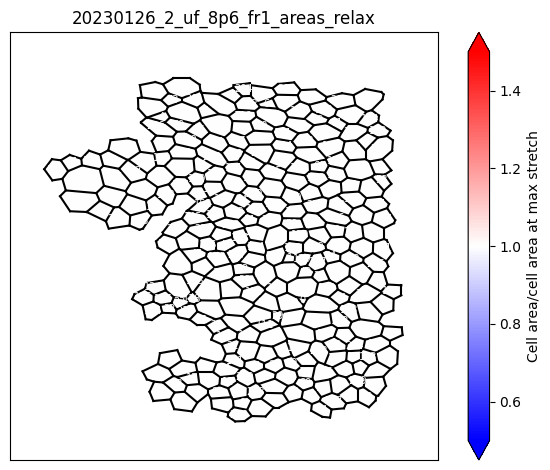

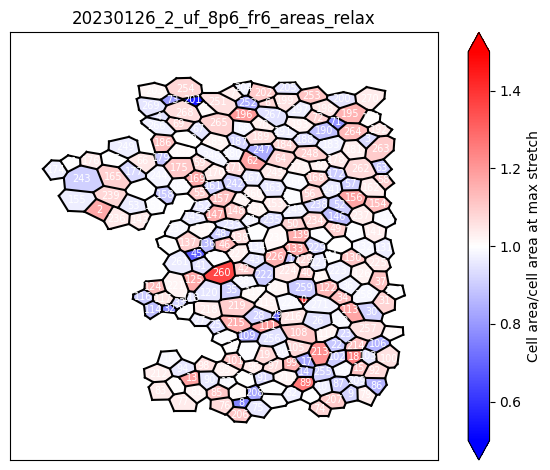

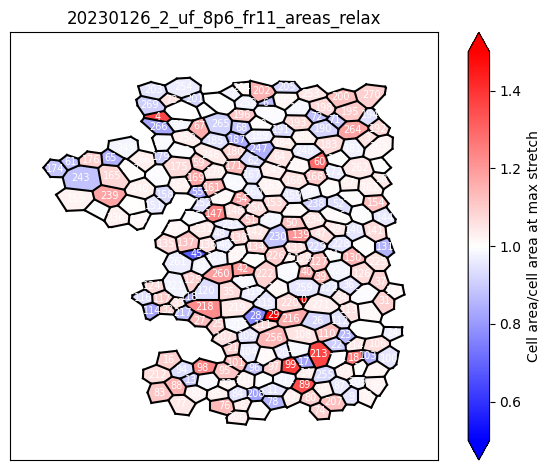

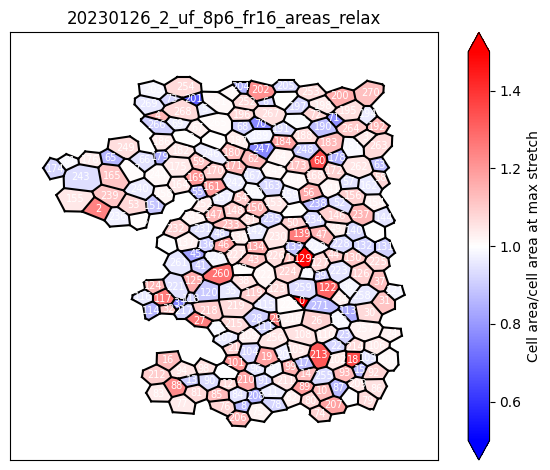

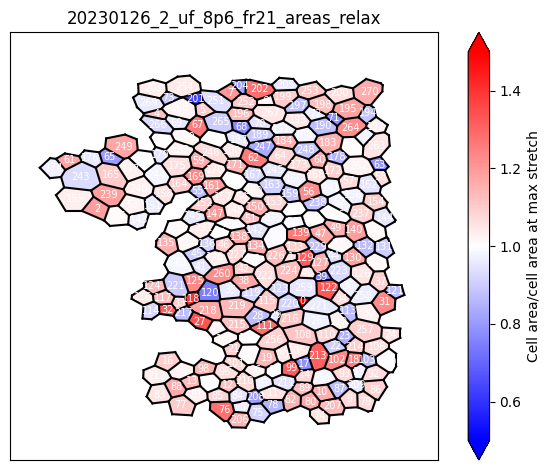

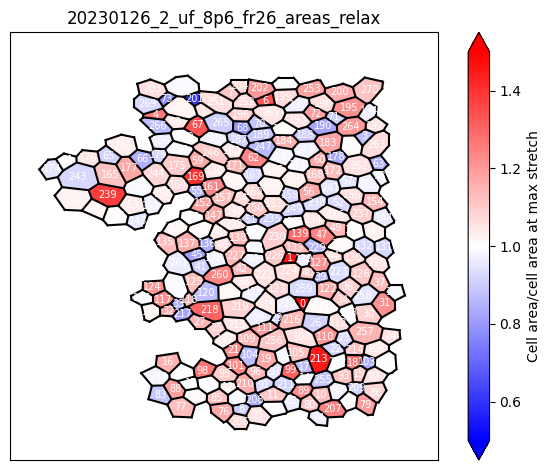

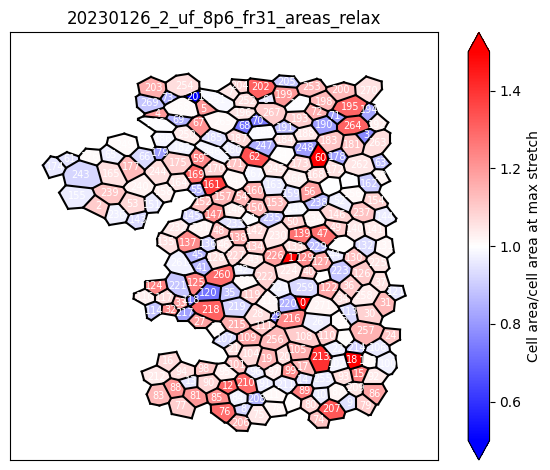

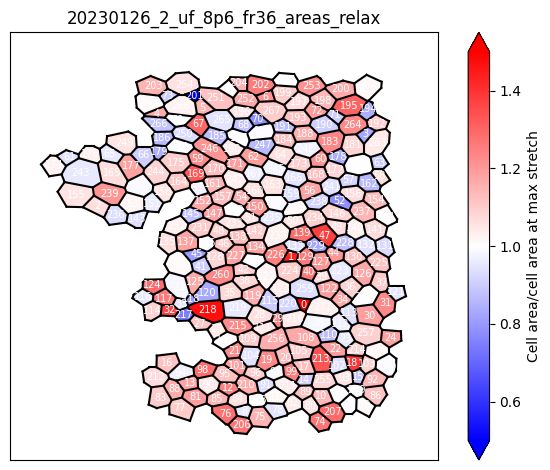

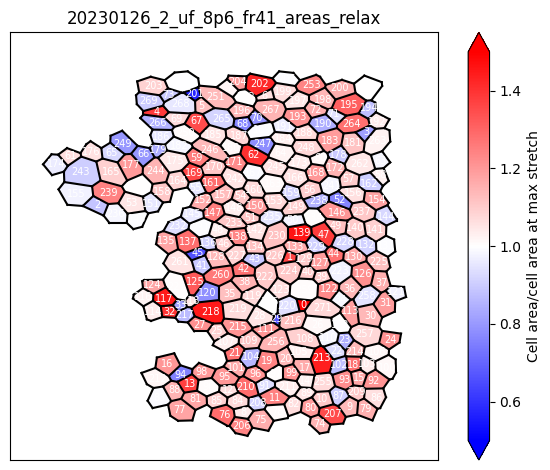

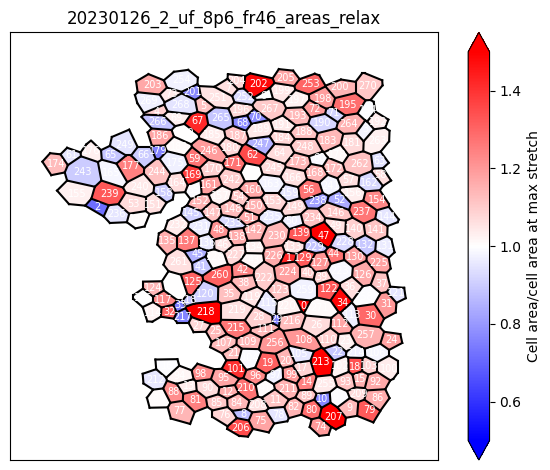

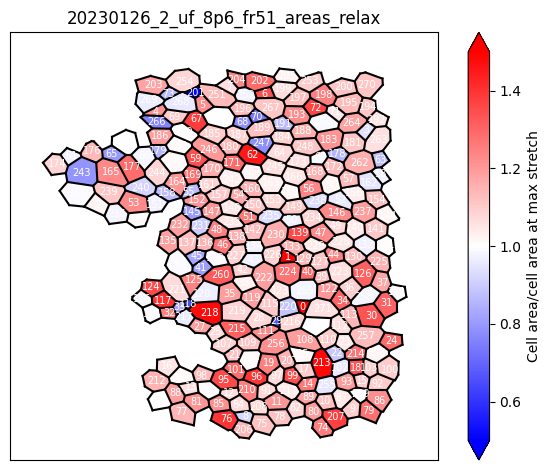

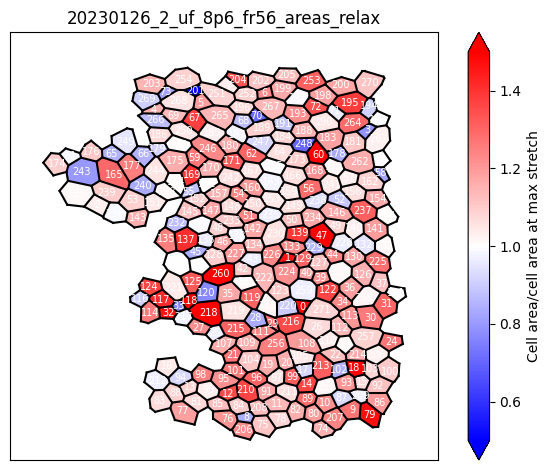

In [453]:
cmap='bwr'
label='Cell area/cell area at max stretch'
#plot_cmap(cell_areas_0/cell_areas_0, cmap,save_dir, '0p5', '1', "20230126_2_uf_0p5_fr1_areas", label, A_0, B_0, C_0, R_0, cc_0, 0.5, 1.5)
plot_cmap(cell_areas_300/cell_areas_300, cmap,save_dir, '8p6', '1', "20230126_2_uf_8p6_fr1_areas_relax", label, A_300, B_300, C_300, R_300, cc_300, 0.5, 1.5)
plot_cmap(cell_areas_600/cell_areas_300, cmap,save_dir, '8p6', '6', "20230126_2_uf_8p6_fr6_areas_relax",  label, A_600, B_600, C_600, R_600, cc_600, 0.5, 1.5)
plot_cmap(cell_areas_900/cell_areas_300, cmap,save_dir, '8p6', '11', "20230126_2_uf_8p6_fr11_areas_relax",  label, A_900, B_900, C_900, R_900, cc_900, 0.5, 1.5)
plot_cmap(cell_areas_1200/cell_areas_300, cmap,save_dir, '8p6', '16', "20230126_2_uf_8p6_fr16_areas_relax",  label, A_1200, B_1200, C_1200, R_1200, cc_1200, 0.5, 1.5)
plot_cmap(cell_areas_1500/cell_areas_300, cmap,save_dir, '8p6', '21', "20230126_2_uf_8p6_fr21_areas_relax",  label, A_1500, B_1500, C_1500, R_1500, cc_1500, 0.5, 1.5)
plot_cmap(cell_areas_1800/cell_areas_300, cmap,save_dir, '8p6', '26', "20230126_2_uf_8p6_fr26_areas_relax", label, A_1800, B_1800, C_1800, R_1800, cc_1800, 0.5, 1.5)
plot_cmap(cell_areas_2100/cell_areas_300, cmap,save_dir, '8p6', '31', "20230126_2_uf_8p6_fr31_areas_relax",  label, A_2100, B_2100, C_2100, R_2100, cc_2100, 0.5, 1.5)
plot_cmap(cell_areas_2400/cell_areas_300, cmap,save_dir, '8p6', '36', "20230126_2_uf_8p6_fr36_areas_relax", label, A_2400, B_2400, C_2400, R_2400, cc_2400, 0.5, 1.5)
plot_cmap(cell_areas_2700/cell_areas_300, cmap,save_dir, '8p6', '41', "20230126_2_uf_8p6_fr41_areas_relax",  label, A_2700, B_2700, C_2700, R_2700, cc_2700, 0.5, 1.5)
plot_cmap(cell_areas_3000/cell_areas_300, cmap,save_dir, '8p6', '46', "20230126_2_uf_8p6_fr46_areas_relax", label, A_3000, B_3000, C_3000, R_3000, cc_3000, 0.5, 1.5)
plot_cmap(cell_areas_3300/cell_areas_300, cmap,save_dir, '8p6', '51', "20230126_2_uf_8p6_fr51_areas_relax",  label, A_3300, B_3300, C_3300, R_3300, cc_3300, 0.5, 1.5)
plot_cmap(cell_areas_3600/cell_areas_300, cmap,save_dir, '8p6', '56', "20230126_2_uf_8p6_fr56_areas_relax", label, A_3600, B_3600, C_3600, R_3600, cc_3600, 0.5, 1.5)

In [ ]:
cmap='bwr'
label='area_change/initial area'
#plot_cmap(cell_areas_0/cell_areas_0, cmap,save_dir, '0p5', '1', "20230126_2_uf_0p5_fr1_areas", label, A_0, B_0, C_0, R_0, cc_0)
plot_cmap(area_change[:,0]/areas_all[:, 0], cmap,save_dir, '8p6', '1', "20230126_2_uf_8p6_fr1_area_change_frac", label, A_300, B_300, C_300, R_300, cc_300,-0.5, 0.5)
plot_cmap(area_change[:,1]/areas_all[:, 0], cmap,save_dir, '8p6', '6', "20230126_2_uf_8p6_fr6_areas_change_frac",  label, A_600, B_600, C_600, R_600, cc_600,-0.5, 0.5)
plot_cmap(area_change[:,2]/areas_all[:, 0], cmap,save_dir, '8p6', '11', "20230126_2_uf_8p6_fr11_areas_change_frac",  label, A_900, B_900, C_900, R_900, cc_900, -0.5, 0.5)
plot_cmap(area_change[:,3]/areas_all[:, 0], cmap,save_dir, '8p6', '16', "20230126_2_uf_8p6_fr16_areas_change_frac",  label, A_1200, B_1200, C_1200, R_1200, cc_1200,-0.5, 0.5)
plot_cmap(area_change[:,4]/areas_all[:, 0], cmap,save_dir, '8p6', '21', "20230126_2_uf_8p6_fr21_areas_change_frac",  label, A_1500, B_1500, C_1500, R_1500, cc_1500, -0.5, 0.5)
plot_cmap(area_change[:,5]/areas_all[:, 0], cmap,save_dir, '8p6', '26', "20230126_2_uf_8p6_fr26_areas_change_frac", label, A_1800, B_1800, C_1800, R_1800, cc_1800,-0.5, 0.5)
plot_cmap(area_change[:,6]/areas_all[:, 0], cmap,save_dir, '8p6', '31', "20230126_2_uf_8p6_fr31_areas_change_frac",  label, A_2100, B_2100, C_2100, R_2100, cc_2100, -0.5, 0.5)
plot_cmap(area_change[:,7]/areas_all[:, 0], cmap,save_dir, '8p6', '36', "20230126_2_uf_8p6_fr36_areas_change_frac", label, A_2400, B_2400, C_2400, R_2400, cc_2400,-0.5, 0.5)
plot_cmap(area_change[:,8]/areas_all[:, 0], cmap,save_dir, '8p6', '41', "20230126_2_uf_8p6_fr41_areas_change_frac",  label, A_2700, B_2700, C_2700, R_2700, cc_2700, -0.5, 0.5)
plot_cmap(area_change[:,9]/areas_all[:, 0], cmap,save_dir, '8p6', '46', "20230126_2_uf_8p6_fr46_areas_change_frac", label, A_3000, B_3000, C_3000, R_3000, cc_3000, -0.5, 0.5)

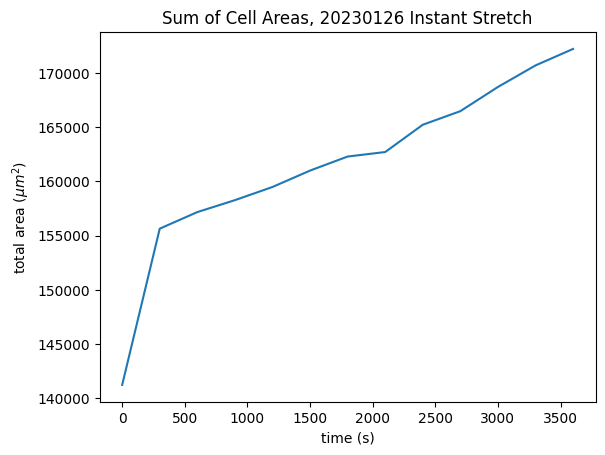

In [312]:
t=np.arange(0,3900,300)
plt.plot(t,np.sum(areas_all, axis=0))
plt.xlabel('time (s)')
plt.ylabel('total area ($\mu m^2$)')
plt.title('Sum of Cell Areas, 20230126 Instant Stretch')
plt.savefig(save_dir+'/20230126_total_area.png', dpi=300)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

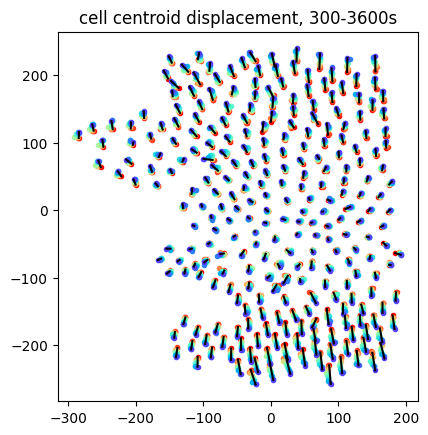

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

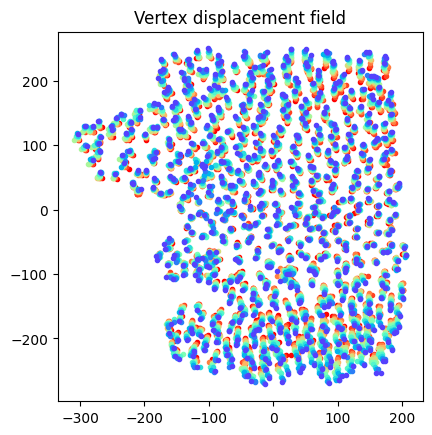

In [462]:
n=13

colour = iter(cm.rainbow_r(np.linspace(0, 1,n)))
for i in range(1,n):
   c = next(colour)
   plt.scatter(cc_x_all[:,i], cc_y_all[:,i], marker='.', c=c)
   #plt.scatter(R_2700[:,0], R_2700[:,1], marker='.')
   #plt.scatter(cc_x_all[199,0], cc_y_all[199,0], marker='+', c='black')

plt.plot([cc_x_all[:,1], cc_x_all[:,-1]],[cc_y_all[:,1], cc_y_all[:,-1]], c='black')
plt.title('cell centroid displacement, 300-3600s')


plt.gca().set_aspect('equal')
plt.savefig(save_dir+'/centred_displacement_cc.png', dpi=300, bbox_inches='tight')
plt.show()



colour = iter(cm.rainbow_r(np.linspace(0, 1,n)))
for i in range(1,n):
   c = next(colour)
   plt.scatter(all_R[i][:,0], all_R[i][:,1], marker='.', c=c)



plt.title('Vertex displacement field')


plt.gca().set_aspect('equal')
#plt.savefig(save_dir+'/centred_displacement_R.png', dpi=300)

In [299]:
np.unique(cell_map[:,0])[np.where(np.unique(cell_map[:,0], return_counts=True)[1]>1)]

array([154.])

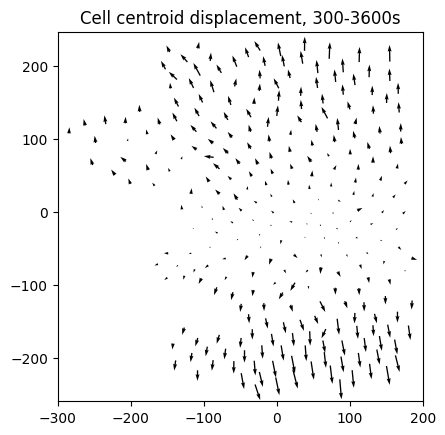

In [461]:
dx_s=cc_x_all[:,1]-cc_x_all[:,0]
dy_s=cc_y_all[:,1]-cc_y_all[:,0]
dx_r=cc_x_all[:,-1]-cc_x_all[:,1]
dy_r=cc_y_all[:,-1]-cc_y_all[:,1]
#plt.axhline(c='red', linestyle='--', linewidth=0.75, zorder=0)
#plt.axvline(c='red', linestyle='--', linewidth=0.75, zorder=0)
#plt.quiver(cc_x_all[:,0],cc_y_all[:,0], dx_s, dy_s,units='xy', angles='xy', scale=1)
plt.quiver(cc_x_all[:,1],cc_y_all[:,1], dx_r, dy_r,units='xy', angles='xy', scale=1, color='black',zorder=10)
plt.gca().set_aspect('equal')
plt.xlim(-300, 200)

plt.title('Cell centroid displacement, 300-3600s')
plt.savefig(save_dir+'/quiver_relax_no_cross.png', dpi=300, bbox_inches='tight')


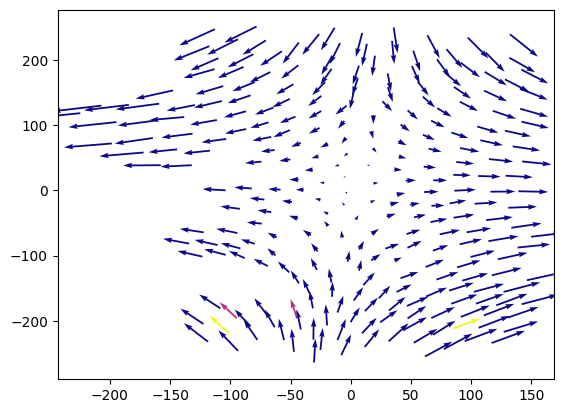

In [336]:
plt.quiver(cc_x_all[:,0],cc_y_all[:,0], dx_s, dy_s,np.gradient(dy_s, cc_y_all[:,1]),units='xy', angles='xy', scale=1, cmap='plasma')

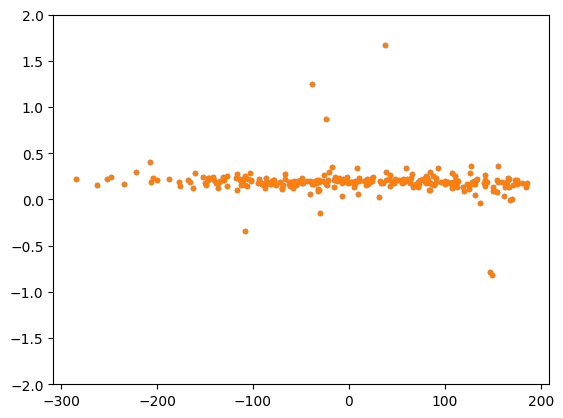

(-100.0, 100.0)

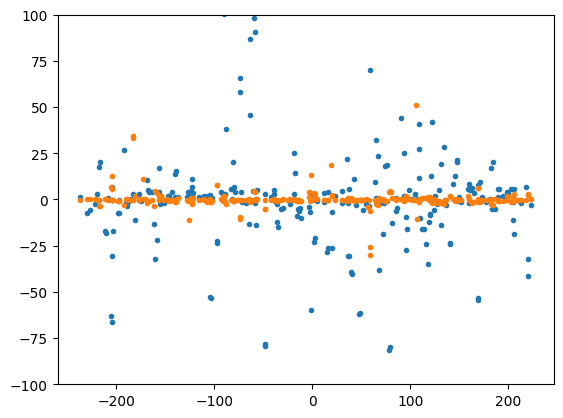

In [356]:
plt.scatter( cc_x_all[:,1],np.gradient(dx_s, cc_x_all[:,1]), marker='.')
plt.scatter( cc_x_all[:,1],np.gradient(dx_s, cc_x_all[:,1]), marker='.')
plt.ylim(-2,2)

plt.show()

plt.scatter( cc_y_all[:,1],np.gradient(dx_s, cc_y_all[:,1]), marker='.')
plt.scatter( cc_y_all[:,1],np.gradient(dy_s, cc_y_all[:,1]), marker='.')
plt.ylim(-100,100)

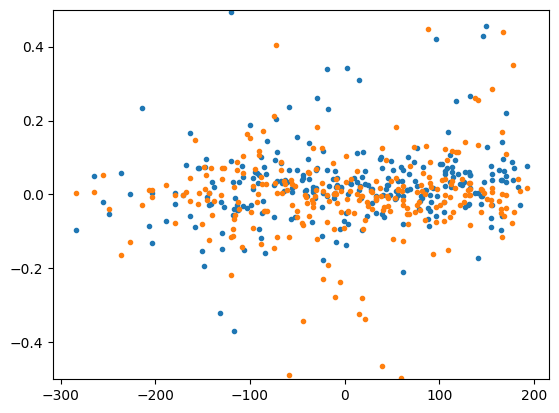

(-25.0, 25.0)

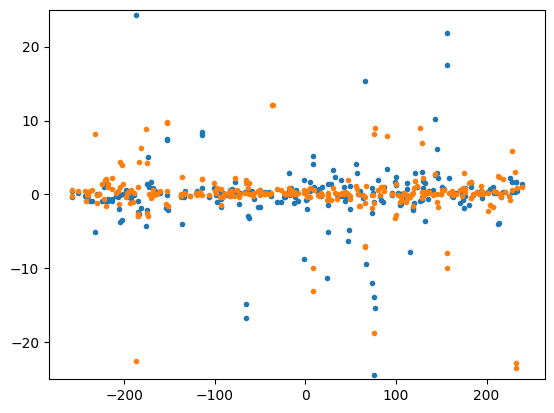

In [351]:
plt.scatter( cc_x_all[:,-1],np.gradient(dx_r, cc_x_all[:,-1]), marker='.')
plt.scatter( cc_x_all[:,-1],np.gradient(dy_r, cc_x_all[:,-1]), marker='.')
plt.ylim(-0.5,0.5)

plt.show()

plt.scatter( cc_y_all[:,-1],np.gradient(dx_r, cc_y_all[:,-1]), marker='.')
plt.scatter( cc_y_all[:,-1],np.gradient(dy_r, cc_y_all[:,-1]), marker='.')
plt.ylim(-25,25)

In [381]:

def strain_fit(X,e1, e2, q):
    rot=np.array([[np.cos(qq), np.sin(qq)], [-np.sin(qq), np.cos(qq)]])
    S=np.array([[e1, 0],[0,e2]])
    ST=rot@S
    
    return ST@X

In [16]:
import cv2
from scipy.linalg import polar
 

In [24]:
plt.p.id_3600)

342

In [26]:
print(cv2.estimateAffine2D(cc_0, cc_300, method=cv2.RANSAC)[0])
print(cv2.estimateAffine2D(cc_0, cc_300, method=cv2.LMEDS)[0])

print(cv2.estimateAffine2D(cc_300, cc_3600, method=cv2.RANSAC, refineIters=0)[0])
print(cv2.estimateAffine2D(cc_300, cc_3600, method=cv2.LMEDS,refineIters=0)[0])

cc_o_300=np.array([cc_orig[0][x]*(micron_size/pixel_size) for x in new_id_map.id_300])
cc_o_3600=np.array([cc_orig[-1][x]*(micron_size/pixel_size) for x in new_id_map.id_3600])

print(cv2.estimateAffine2D(cc_o_300, cc_o_3600, method=cv2.RANSAC, refineIters=0)[0])
print(cv2.estimateAffine2D(cc_o_300, cc_o_3600, method=cv2.LMEDS,refineIters=0)[0])

[[ 1.23141521 -0.0302179   0.27827901]
 [-0.00837861  0.89087501  0.28334296]]
[[ 1.23590363 -0.03148326  0.18142329]
 [-0.00887235  0.89109975  0.15094735]]
[[ 1.01352474 -0.01069596 -1.81549694]
 [-0.01454472  1.10076807  1.65975202]]
[[ 1.01352474 -0.01069596 -1.81549694]
 [-0.01454472  1.10076807  1.65975202]]
[[ 1.01352467e+00 -1.06958410e-02 -1.46957032e+01]
 [-1.45445413e-02  1.10076802e+00 -2.97855525e+01]]
[[ 1.01352467e+00 -1.06958410e-02 -1.46957032e+01]
 [-1.45445413e-02  1.10076802e+00 -2.97855525e+01]]


In [415]:
af=np.array([[ 1.23141521, -0.0302179 ],
        [-0.00837861,  0.89087501]])
b=np.array([ 0.27827901,0.28334296])

af2=np.array([[ 1.23590363, -0.03148326],[-0.00887235,  0.89109975 ]])
b2=np.array([0.18142329, 0.15094735])


cc_300_prime=np.zeros_like(cc_300)
cc_300_prime2=np.zeros_like(cc_300)
for i in range(len(cc_0)):
        cc_300_prime[i]=af@cc_0[i]#+b
        cc_300_prime2[i]=af2@cc_0[i]#+b2

In [442]:
sx=np.sqrt(af[0,0]**2+af[1,0]**2)
q=np.arctan2(af[1,0], af[0,0])
msy=af[0,1]*np.cos(q)+af[1,1]*np.sin(q)
sy=(msy*np.cos(q)-af[0,1])/np.sin(q)
m=msy/sy

print(sx, sy, q, m)

print(polar(af))
print(polar(af2))


1.2314437139085472 0.8906487898197488 -0.006803944469246742 -0.04073279871714148
(array([[ 0.99994706, -0.01028989],
       [ 0.01028989,  0.99994706]]), array([[ 1.2312638 , -0.02104929],
       [-0.02104929,  0.89113878]]))
(array([[ 0.9999435 , -0.01062981],
       [ 0.01062981,  0.9999435 ]]), array([[ 1.23573949, -0.02200926],
       [-0.02200926,  0.89138407]]))


In [448]:
print(0.5*(af.T +af)-np.eye(2))
print(0.5*(af-af.T))

[[ 0.23141521 -0.01929826]
 [-0.01929826 -0.10912499]]
[[ 0.         -0.01091964]
 [ 0.01091964  0.        ]]


In [424]:
(np.array([[np.cos(q), -np.sin(q)], [np.sin(q), np.cos(q)]])@np.array([[1,m],[0,1]])@np.array([[sx, 0], [0, sy]]))-af

array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.33226763e-15]])

In [427]:
cc0=np.array([cc_0_orig[x] for x in new_id_map.id_0.astype(int)])
cc300=np.array([cc_orig[0][x] for x in new_id_map.id_300.astype(int)])

In [435]:
print(cv2.estimateAffine2D(cc_0, cc_300, method=cv2.RANSAC)[0])
print(cv2.estimateAffine2D(cc_0, cc_300, method=cv2.LMEDS)[0])
print('\n')
print(cv2.estimateAffine2D(R_0, R_300, method=cv2.RANSAC)[0])
print(cv2.estimateAffine2D(R_0, R_300, method=cv2.LMEDS)[0])
print('\n')
print(cv2.estimateAffine2D(cc0, cc300, method=cv2.RANSAC)[0])
print(cv2.estimateAffine2D(cc0, cc300, method=cv2.LMEDS)[0])

[[ 1.23141521 -0.0302179   0.27827901]
 [-0.00837861  0.89087501  0.28334296]]
[[ 1.23590363 -0.03148326  0.18142329]
 [-0.00887235  0.89109975  0.15094735]]


[[ 1.24189802 -0.02649392 -0.14518047]
 [-0.00314737  0.89622968  0.57186422]]
[[ 1.74858582e-01 -9.99248473e-02 -4.52412900e-08]
 [-2.06804642e-04  8.91760848e-01  3.56406268e-07]]


[[ 1.23537635e+00 -3.20756180e-02 -3.59911326e+01]
 [-1.36967926e-02  8.81955118e-01  6.44880365e+01]]
[[ 1.23590362e+00 -3.14832666e-02 -3.71188503e+01]
 [-8.87233451e-03  8.91099756e-01  5.45640000e+01]]


In [437]:
print(cv2.estimateAffine2D(cc_300, cc_3600, method=cv2.RANSAC)[0])
print(cv2.estimateAffine2D(cc_300, cc_3600, method=cv2.LMEDS)[0])
print('\n')
#print(cv2.estimateAffine2D(R_300, R_3600, method=cv2.RANSAC)[0])
#print(cv2.estimateAffine2D(R_300, R_3600, method=cv2.LMEDS)[0])


[[ 1.01603755 -0.01020323 -1.7155307 ]
 [-0.01425555  1.09891643  1.69805097]]
[[ 1.01527944 -0.01138223 -1.01923178]
 [-0.00297537  1.09137322  0.40039654]]




In [445]:
polar(np.array([[ 1.01603755,-0.01020323],[-0.01425555,  1.09891643]]))

(array([[ 0.99999816,  0.00191603],
        [-0.00191603,  0.99999816]]),
 array([[ 1.016063  , -0.01230877],
        [-0.01230877,  1.09889486]]))

In [433]:
len(R_0)
len(R_300)

635

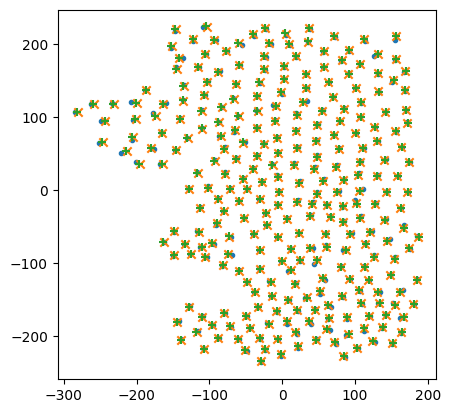

In [416]:
#plt.scatter(cc_0[:,0], cc_0[:,1], marker='.')
plt.scatter(cc_300[:,0], cc_300[:,1], marker='.')
plt.scatter(cc_300_prime[:,0], cc_300_prime[:,1], marker='x')
plt.scatter(cc_300_prime2[:,0], cc_300_prime2[:,1], marker='+')
plt.gca().set_aspect('equal')

In [380]:
ds_s=np.transpose(np.vstack((dx_s,dy_s)))

np.linalg.pinv(cc_300.T).dot(ds_s.T).T

array([[ 5.70289331e-05,  1.58159693e-04, -9.59416251e-04, ...,
        -1.30467319e-04,  1.46571149e-03,  1.53379618e-04],
       [ 9.88565284e-05,  1.18592813e-04, -6.76886731e-04, ...,
        -2.43181391e-04,  8.07380845e-04,  1.67804495e-04],
       [-7.40635526e-04, -6.55388795e-04,  3.59346699e-03, ...,
         1.84742971e-03, -3.45157842e-03, -1.11024135e-03],
       ...,
       [-2.27329957e-04, -4.22031427e-04,  2.50313796e-03, ...,
         5.42879386e-04, -3.52033470e-03, -4.80011522e-04],
       [ 8.78886604e-04,  3.75205647e-04, -1.71250088e-03, ...,
        -2.23632796e-03, -3.89045382e-04,  1.06373447e-03],
       [ 1.14862185e-04,  1.86177126e-04, -1.09320012e-03, ...,
        -2.77259938e-04,  1.47719002e-03,  2.25474260e-04]])

In [357]:

poptxx, pcovxx = curve_fit(f, cc_x_all[:,1], np.gradient(dx_s, cc_x_all[:,1]))
print(poptxx)

#poptxy, pcovxy = curve_fit(f, cc_y_all[:,1], np.gradient(dx_s, cc_y_all[:,1]))
#print(poptxy)

poptyx, pcovyx = curve_fit(f, cc_x_all[:,1], np.gradient(dy_s, cc_x_all[:,1]))
print(poptyx)

poptyy, pcovyy = curve_fit(f, cc_y_all[:,1], np.gradient(dy_s, cc_y_all[:,1]))
print(poptyy)

[-5.74849716e-05  1.82712447e-01]
[0.00059373 0.01515321]


ValueError: array must not contain infs or NaNs

In [ ]:
n=8

colour = iter(cm.rainbow_r(np.linspace(0, 1,n)))
for i in range(1,n):
   c = next(colour)
   plt.scatter(cc_orig[i][:,0], cc_orig[i][:,1], marker='.', c=c)
   #plt.scatter(R_2700[:,0], R_2700[:,1], marker='.')
#plt.scatter(cc_orig[0][:,0], cc_orig[0][:,1], marker='x', c='black')

plt.title('cell centres displacement field')


plt.gca().set_aspect('equal')
plt.savefig(save_dir+'/displacement_cc.png', dpi=300)
plt.show()



colour = iter(cm.rainbow_r(np.linspace(0, 1,n)))
for i in range(1,n):
   c = next(colour)
   plt.scatter(R_orig[i][:,0], R_orig[i][:,1], marker='.', c=c)



plt.title('Vertex displacement field')


plt.gca().set_aspect('equal')
plt.savefig(save_dir+'/displacement_R.png', dpi=300)

In [ ]:
plt.plot(cc0)

In [ ]:

# n=8

# colour = iter(cm.rainbow_r(np.linspace(0, 1,n)))
# for i in range(1,n):
#    c = next(colour)
#    plt.scatter(cc_orig[i][:,0]*(micron_size/pixel_size)-stage_pos[1, -2], cc_orig[i][:,1]*(micron_size/pixel_size)-stage_pos[1, -1], marker='.', c=c)
#    #plt.scatter(R_2700[:,0], R_2700[:,1], marker='.')
# plt.scatter(R0[:,0]*(micron_size/pixel_size)-stage_pos[0, -2], R0[:,1]*(micron_size/pixel_size)-stage_pos[0, -1], marker='x', c='black')
# plt.scatter(R_orig[0][:,0]*(micron_size/pixel_size)-stage_pos[1, -2], R_orig[0][:,1]*(micron_size/pixel_size)-stage_pos[1, -1], marker='+', c='red')


# plt.scatter((cc_0[:,0]+np.mean(cc_0_orig*(micron_size/pixel_size), axis=0)[0])-stage_pos[0, -2], (cc_0[:,1]+np.mean(cc_0_orig*(micron_size/pixel_size), axis=0)[1])-stage_pos[0, -1], marker='x', c='black')
# #plt.scatter((cc_300[:,0]+np.mean(cc_orig[0][:,0]))*(micron_size/pixel_size)-stage_pos[1, -2], (cc_300[:,1]+np.mean(cc_orig[0][:,1]))*(micron_size/pixel_size)-stage_pos[1, -1], marker='+', c='red')
# plt.scatter((cc_300[:,0]+np.mean(cc_orig[0][:,0]*(micron_size/pixel_size)))-stage_pos[1, -2], (cc_300[:,1]+np.mean(cc_orig[0][:,1]*(micron_size/pixel_size)))-stage_pos[1, -1], marker='+', c='red')
# plt.scatter((cc_2400[:,0]+np.mean(cc_orig[-1][:,0]*(micron_size/pixel_size)))-stage_pos[1, -2], (cc_2400[:,1]+np.mean(cc_orig[-1][:,1]*(micron_size/pixel_size)))-stage_pos[1, -1], marker='+', c='green')

plt.scatter(cc_0[:,0]+stage_pos[0, -2], cc_0[:,1]+stage_pos[0, -1], marker='x', c='black')

plt.scatter(cc_300[:,0]+stage_pos[1, -2], cc_300[:,1]+stage_pos[1, -1], marker='+', c='red')
plt.scatter(cc_2400[:,0]+stage_pos[1, -2], cc_2400[:,1]+stage_pos[1, -1], marker='+', c='green')


plt.gca().set_aspect('equal')
#plt.savefig(save_dir+'/displacement_cc.png', dpi=300)

In [ ]:
plt.scatter(cc_orig[0][:,0]*(micron_size/pixel_size)-stage_pos[0, -2], cc_orig[0][:,1]*(micron_size/pixel_size)-stage_pos[0, -1], marker='x', c='black')
plt.scatter(cc_orig[1][:,0]*(micron_size/pixel_size)-stage_pos[1, -2], cc_orig[1][:,1]*(micron_size/pixel_size)-stage_pos[1, -1], marker='+', c='red')

plt.title('cell centres displacement field')


plt.gca().set_aspect('equal')

In [ ]:
cmap='viridis'
label='Cell area/Initial cell area'
plot_cmap(cell_areas_0/cell_areas_0, cmap,save_dir, '0p5', '1', "20230126_2_uf_0p5_fr1_areas_check_index", label, A_0, B_0, C_0, R_0, cc_0)
plot_cmap(cell_areas_300/cell_areas_0, cmap,save_dir, '8p6', '1', "20230126_2_uf_8p6_fr1_areas", label, A_300, B_300, C_300, R_300, cc_300)
# plot_cmap(cell_areas_600/cell_areas_0, cmap,save_dir, '8p6', '6', "20230126_2_uf_8p6_fr6_areas",  label, A_600, B_600, C_600, R_600, cc_600)
# plot_cmap(cell_areas_900/cell_areas_0, cmap,save_dir, '8p6', '11', "20230126_2_uf_8p6_fr11_areas",  label, A_900, B_900, C_900, R_900, cc_900)
# plot_cmap(cell_areas_1200/cell_areas_0, cmap,save_dir, '8p6', '16', "20230126_2_uf_8p6_fr16_areas",  label, A_1200, B_1200, C_1200, R_1200, cc_1200)
# plot_cmap(cell_areas_1500/cell_areas_0, cmap,save_dir, '8p6', '21', "20230126_2_uf_8p6_fr21_areas",  label, A_1500, B_1500, C_1500, R_1500, cc_1500)
#plot_cmap(cell_areas_1800/cell_areas_0, cmap,save_dir, '8p6', '26', "20230126_2_uf_8p6_fr26_areas_check_index", label, A_1800, B_1800, C_1800, R_1800, cc_1800)

In [ ]:
mat_dir_t_0=glob(o_folder+'\\'+exp_id+'_'+ '0p5' + '*_*P_fr*'+'1'+'\\*\\Matrices')[0]
A_0  = np.loadtxt(glob(mat_dir_t_0+'/*Matrix_A*.txt')[0]) # Incidence matrix. Rows => edges; columns => vertices.
B_0  = np.loadtxt(glob(mat_dir_t_0+'/*Matrix_B*.txt')[0]) # Incidence matrix. Rows => cells; columns => edges.
C_0  = np.loadtxt(glob(mat_dir_t_0+'/*Matrix_C*.txt')[0]) # Incidence matrix. Rows => cells; columns => vertices. 
R_0  = np.loadtxt(glob(mat_dir_t_0+'/*Matrix_R*.txt')[0])

mat_dir_t_300=glob(o_folder+'\\'+exp_id+'_'+ '8p6' + '*_*P_fr*'+'01'+'\\*\\Matrices')[0]
A_300  = np.loadtxt(glob(mat_dir_t_300+'/*Matrix_A*.txt')[0]) # Incidence matrix. Rows => edges; columns => vertices.
B_300  = np.loadtxt(glob(mat_dir_t_300+'/*Matrix_B*.txt')[0]) # Incidence matrix. Rows => cells; columns => edges.
C_300  = np.loadtxt(glob(mat_dir_t_300+'/*Matrix_C*.txt')[0]) # Incidence matrix. Rows => cells; columns => vertices. 
R_300  = np.loadtxt(glob(mat_dir_t_300+'/*Matrix_R*.txt')[0])

mat_dir_t_600=glob(o_folder+'\\'+exp_id+'_'+ '8p6' + '*_*P_fr*'+'06'+'\\*\\Matrices')[0]
A_600  = np.loadtxt(glob(mat_dir_t_600+'/*Matrix_A*.txt')[0]) # Incidence matrix. Rows => edges; columns => vertices.
B_600  = np.loadtxt(glob(mat_dir_t_600+'/*Matrix_B*.txt')[0]) # Incidence matrix. Rows => cells; columns => edges.
C_600  = np.loadtxt(glob(mat_dir_t_600+'/*Matrix_C*.txt')[0]) # Incidence matrix. Rows => cells; columns => vertices. 
R_600  = np.loadtxt(glob(mat_dir_t_600+'/*Matrix_R*.txt')[0])

mat_dir_t_900=glob(o_folder+'\\'+exp_id+'_'+ '8p6' + '*_*P_fr*'+'11'+'\\*\\Matrices')[0]
A_900  = np.loadtxt(glob(mat_dir_t_900+'/*Matrix_A*.txt')[0]) # Incidence matrix. Rows => edges; columns => vertices.
B_900  = np.loadtxt(glob(mat_dir_t_900+'/*Matrix_B*.txt')[0]) # Incidence matrix. Rows => cells; columns => edges.
C_900  = np.loadtxt(glob(mat_dir_t_900+'/*Matrix_C*.txt')[0]) # Incidence matrix. Rows => cells; columns => vertices. 
R_900  = np.loadtxt(glob(mat_dir_t_900+'/*Matrix_R*.txt')[0])

mat_dir_t_1200=glob(o_folder+'\\'+exp_id+'_'+ '8p6' + '*_*P_fr*'+'16'+'\\*\\Matrices')[0]
A_1200  = np.loadtxt(glob(mat_dir_t_1200+'/*Matrix_A*.txt')[0]) # Incidence matrix. Rows => edges; columns => vertices.
B_1200  = np.loadtxt(glob(mat_dir_t_1200+'/*Matrix_B*.txt')[0]) # Incidence matrix. Rows => cells; columns => edges.
C_1200  = np.loadtxt(glob(mat_dir_t_1200+'/*Matrix_C*.txt')[0]) # Incidence matrix. Rows => cells; columns => vertices. 
R_1200  = np.loadtxt(glob(mat_dir_t_1200+'/*Matrix_R*.txt')[0])


mat_dir_t_1500=glob(o_folder+'\\'+exp_id+'_'+ '8p6' + '*_*P_fr*'+'21'+'\\*\\Matrices')[0]
A_1500  = np.loadtxt(glob(mat_dir_t_1500+'/*Matrix_A*.txt')[0]) # Incidence matrix. Rows => edges; columns => vertices.
B_1500  = np.loadtxt(glob(mat_dir_t_1500+'/*Matrix_B*.txt')[0]) # Incidence matrix. Rows => cells; columns => edges.
C_1500  = np.loadtxt(glob(mat_dir_t_1500+'/*Matrix_C*.txt')[0]) # Incidence matrix. Rows => cells; columns => vertices. 
R_1500  = np.loadtxt(glob(mat_dir_t_1500+'/*Matrix_R*.txt')[0])

mat_dir_t_1800=glob(o_folder+'\\'+exp_id+'_'+ '8p6' + '*_*P_fr*'+'26'+'\\*\\Matrices')[0]
A_1800  = np.loadtxt(glob(mat_dir_t_1800+'/*Matrix_A*.txt')[0]) # Incidence matrix. Rows => edges; columns => vertices.
B_1800  = np.loadtxt(glob(mat_dir_t_1800+'/*Matrix_B*.txt')[0]) # Incidence matrix. Rows => cells; columns => edges.
C_1800  = np.loadtxt(glob(mat_dir_t_1800+'/*Matrix_C*.txt')[0]) # Incidence matrix. Rows => cells; columns => vertices. 
R_1800  = np.loadtxt(glob(mat_dir_t_1800+'/*Matrix_R*.txt')[0])

In [ ]:
glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\Code\\tissue_image_analysis\\tissue_image_analysis\\Output\\20230126_2_IN_CheHis-BFPCAAX_uf_8p6*_MP_fr1\\*\\Matrices')

In [ ]:
cell_edge_count_0=geometry.get_edge_count(B_0)
cell_centres_0=geometry.get_cell_centres(C_0,R_0,cell_edge_count_0)
cell_edge_count_300=geometry.get_edge_count(B_300)
cell_centres_300=geometry.get_cell_centres(C_300,R_300,cell_edge_count_300)
cell_edge_count_600=geometry.get_edge_count(B_600)
cell_centres_600=geometry.get_cell_centres(C_600,R_600,cell_edge_count_600)
cell_edge_count_900=geometry.get_edge_count(B_900)
cell_centres_900=geometry.get_cell_centres(C_900,R_900,cell_edge_count_900)
cell_edge_count_1200=geometry.get_edge_count(B_1200)
cell_centres_1200=geometry.get_cell_centres(C_1200,R_1200,cell_edge_count_1200)
cell_edge_count_1500=geometry.get_edge_count(B_1500)
cell_centres_1500=geometry.get_cell_centres(C_1500,R_1500,cell_edge_count_1500)
cell_edge_count_1800=geometry.get_edge_count(B_1800)
cell_centres_1800=geometry.get_cell_centres(C_1800,R_1800,cell_edge_count_1800)

In [ ]:
tm_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230126/spot_id_overlap_1-26_2.csv', skiprows=[1,2,3])

In [ ]:
len(cell_centres_300)+len(cell_centres_600)+len(cell_centres_900)+len(cell_centres_1200)+len(cell_areas_1500)+len(cell_centres_1800)

In [ ]:
tm_dat_fr_0=tm_dat[tm_dat.FRAME==0]
tm_dat_fr_1=tm_dat[tm_dat.FRAME==1]
tm_dat_fr_2=tm_dat[tm_dat.FRAME==2]
tm_dat_fr_3=tm_dat[tm_dat.FRAME==3]
tm_dat_fr_4=tm_dat[tm_dat.FRAME==4]
tm_dat_fr_5=tm_dat[tm_dat.FRAME==5]

In [ ]:
tm_dat_fr_0.shape

In [ ]:
plt.axhline(0, linestyle='--', color='red', linewidth=0.75)
plt.axvline(0, linestyle='--', color='red', linewidth=0.75)

plt.scatter((tm_dat_fr_0.POSITION_X-np.mean(tm_dat_fr_0.POSITION_X))*0.89, ((-tm_dat_fr_0.POSITION_Y)-np.mean(-tm_dat_fr_0.POSITION_Y))*0.89, marker='.')
plt.scatter(cell_centres_300[:,0]-np.mean(cell_centres_300[:,0]), cell_centres_300[:,1]-np.mean(cell_centres_300[:,1]),marker='.')

plt.gca().set_aspect('equal')

In [ ]:
plt.axhline(0, linestyle='--', color='red', linewidth=0.75)
plt.axvline(0, linestyle='--', color='red', linewidth=0.75)

plt.scatter((tm_dat_fr_1.POSITION_X-np.mean(tm_dat_fr_1.POSITION_X))*0.89, ((-tm_dat_fr_1.POSITION_Y)-np.mean(-tm_dat_fr_1.POSITION_Y))*0.89, marker='.')
plt.scatter(cell_centres_600[:,0]-np.mean(cell_centres_600[:,0]), cell_centres_600[:,1]-np.mean(cell_centres_600[:,1]),marker='.')

plt.gca().set_aspect('equal')

In [ ]:
plt.axhline(0, linestyle='--', color='red', linewidth=0.75)
plt.axvline(0, linestyle='--', color='red', linewidth=0.75)
plt.scatter((tm_dat_fr_2.POSITION_X-np.mean(tm_dat_fr_2.POSITION_X))*0.89, ((-tm_dat_fr_2.POSITION_Y)-np.mean(-tm_dat_fr_2.POSITION_Y))*0.89, marker='.')
plt.scatter(cell_centres_900[:,0]-np.mean(cell_centres_900[:,0]), cell_centres_900[:,1]-np.mean(cell_centres_900[:,1]),marker='.')
plt.gca().set_aspect('equal')

In [ ]:
plt.axhline(0, linestyle='--', color='red', linewidth=0.75)
plt.axvline(0, linestyle='--', color='red', linewidth=0.75)
plt.axhline(0, linestyle='--', color='red', linewidth=0.75)
plt.axvline(0, linestyle='--', color='red', linewidth=0.75)
plt.scatter((tm_dat_fr_3.POSITION_X-np.mean(tm_dat_fr_3.POSITION_X))*0.89, ((-tm_dat_fr_3.POSITION_Y)-np.mean(-tm_dat_fr_3.POSITION_Y))*0.89, marker='.')
plt.scatter(cell_centres_1200[:,0]-np.mean(cell_centres_1200[:,0]), cell_centres_1200[:,1]-np.mean(cell_centres_1200[:,1]),marker='.')
plt.gca().set_aspect('equal')

In [ ]:
plt.axhline(0, linestyle='--', color='red', linewidth=0.75)
plt.axvline(0, linestyle='--', color='red', linewidth=0.75)
plt.scatter((tm_dat_fr_4.POSITION_X-np.mean(tm_dat_fr_4.POSITION_X))*0.89, ((-tm_dat_fr_4.POSITION_Y)-np.mean(-tm_dat_fr_4.POSITION_Y))*0.89, marker='.')
plt.scatter(cell_centres_1500[:,0]-np.mean(cell_centres_1500[:,0]), cell_centres_1500[:,1]-np.mean(cell_centres_1500[:,1]),marker='.')
#plt.scatter((cell_centres_1500[:,0]-np.mean(cell_centres_1500[:,0]))[101], (cell_centres_1500[:,1]-np.mean(cell_centres_1500[:,1]))[101],marker='.')
#plt.scatter((cell_centres_1500[:,0]-np.mean(cell_centres_1500[:,0]))[243], (cell_centres_1500[:,1]-np.mean(cell_centres_1500[:,1]))[243],marker='.')
#plt.scatter(((tm_dat_fr_4.POSITION_X-np.mean(tm_dat_fr_4.POSITION_X))*0.875).iloc[154], (((-tm_dat_fr_4.POSITION_Y)-np.mean(-tm_dat_fr_4.POSITION_Y))*0.875).iloc[154], marker='x')
plt.gca().set_aspect('equal')

In [ ]:
((tm_dat_fr_4.POSITION_X-np.mean(tm_dat_fr_4.POSITION_X))*0.875).iloc[154]

In [ ]:
plt.axhline(0, linestyle='--', color='red', linewidth=0.75)
plt.axvline(0, linestyle='--', color='red', linewidth=0.75)
plt.scatter((tm_dat_fr_5.POSITION_X-np.mean(tm_dat_fr_5.POSITION_X))*0.89, ((-tm_dat_fr_5.POSITION_Y)-np.mean(-tm_dat_fr_5.POSITION_Y))*0.89, marker='.')
plt.scatter(cell_centres_1800[:,0]-np.mean(cell_centres_1800[:,0]), cell_centres_1800[:,1]-np.mean(cell_centres_1800[:,1]),marker='.')
plt.gca().set_aspect('equal')

In [ ]:
tm_centres_300=np.transpose(np.vstack(((tm_dat_fr_0.POSITION_X-np.mean(tm_dat_fr_0.POSITION_X))*0.875, (-tm_dat_fr_0.POSITION_Y-np.mean(-tm_dat_fr_0.POSITION_Y))*0.875)))
cc_300=cell_centres_300-np.mean(cell_centres_300, axis=0)
tm_centres_1500=np.transpose(np.vstack(((tm_dat_fr_4.POSITION_X-np.mean(tm_dat_fr_4.POSITION_X))*0.875, (-tm_dat_fr_4.POSITION_Y-np.mean(-tm_dat_fr_4.POSITION_Y))*0.875)))
cc_1500=cell_centres_1500-np.mean(cell_centres_1500, axis=0)

In [ ]:
min_diff=[]
cd=cdist(cc_1500, tm_centres_1500)
for i in range(len(cc_1500)):
    cds=sorted(cd[i])
    min_diff.append(cds[1]-cds[0])

plt.plot(min_diff)

In [ ]:
plt.scatter(cell_centres_0[cell_map[:,0].astype(int)][:,0], cell_centres_0[cell_map[:,0].astype(int)][:,1], marker='.')
plt.scatter(cell_centres_300[cell_map[:,1].astype(int)][:,0], cell_centres_300[cell_map[:,1].astype(int)][:,1], marker='.')
plt.gca().set_aspect('equal')

In [ ]:
cell_map[:,0].astype(int)

In [ ]:
min_id=[]
for i in range(len(cc_300)):
    min_id.append(np.where(cdist(cc_300, tm_centres_300)[i]==min(cdist(cc_300, tm_centres_300)[i]))[0][0])

In [ ]:
tm_dat_fr_0.iloc[min_id]

In [ ]:
ids_300=pd.DataFrame(data=np.transpose(np.vstack((np.linspace(0,len(cc_300)-1, len(cc_300)), min_id,tm_dat_fr_0.iloc[min_id].TRACK_ID ))).astype(int), columns=['id', 'tm_index', 'track_id']).dropna()

In [ ]:
ids_300

In [ ]:
plt.scatter((tm_dat_fr_1.POSITION_X-np.mean(tm_dat_fr_1.POSITION_X))*0.875, ((-tm_dat_fr_1.POSITION_Y)-np.mean(-tm_dat_fr_1.POSITION_Y))*0.875, marker='.')
plt.scatter(cell_centres_600[:,0]-np.mean(cell_centres_600[:,0]), cell_centres_600[:,1]-np.mean(cell_centres_600[:,1]),marker='.')
plt.gca().set_aspect('equal')

In [ ]:
tm_centres_600=np.transpose(np.vstack(((tm_dat_fr_1.POSITION_X-np.mean(tm_dat_fr_1.POSITION_X))*0.875, (-tm_dat_fr_1.POSITION_Y-np.mean(-tm_dat_fr_1.POSITION_Y))*0.875)))
cc_600=cell_centres_600-np.mean(cell_centres_600, axis=0)
min_id_600=[]
for i in range(len(cc_600)):
    min_id_600.append(np.where(cdist(cc_600, tm_centres_600)[i]==min(cdist(cc_600, tm_centres_600)[i]))[0][0])

In [ ]:
ids_600=pd.DataFrame(data=np.transpose(np.vstack((np.linspace(0,len(cc_600)-1, len(cc_600)), min_id_600,tm_dat_fr_1.iloc[min_id_600].TRACK_ID ))).astype(int), columns=['id', 'tm_index', 'track_id']).dropna()

In [ ]:
id_map=ids_300.merge(ids_600, on='track_id', how='inner', suffixes=['_300', '_600'])

In [ ]:
A_300, B_300, C_300, R_300, cc_300=reindex_data(o_folder, save_dir,'8p6', '1', pixel_size, micron_size, stage_pos[1, -2:], id_map.id_300)
cell_areas_300=geometry.get_areas(A_300, B_300, R_300)

A_600, B_600, C_600, R_600, cc_600=reindex_data(o_folder, save_dir,'8p6', '6', pixel_size, micron_size, stage_pos[1, -2:], id_map.id_600)
cell_areas_600=geometry.get_areas(A_600, B_600, R_600)

In [ ]:
plot_cmap(cell_areas_300, 'viridis',save_dir, '8p6', '1', "20230126_2_uf_8p6_fr1_areas", 'Area', A_300, B_300, C_300, R_300, cc_300)
plot_cmap(cell_areas_600, 'viridis',save_dir, '8p6', '6', "20230126_2_uf_8p6_fr6_areas", 'Area', A_600, B_600, C_600, R_600, cc_600)


In [ ]:
np.where(cec_0)